## Data Science Challenge - Product

Purpose: Understanding user behaviour, and showcasing my data science skills. 

Please make note this is a sample notebook and can not be run without PostgresSQL connection.


In [1]:
# import required libraries

import os
import sys

import pandas as pd
import psycopg2
from pylab import rcParams
import numpy as np 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import scipy.stats as stats

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.data.connect_postgres as cp
from src.features.FeatureSelector import FeatureSelector 
from src.models.MLPipeline import MLPipeline


%matplotlib inline

In [2]:
# Create the connection to postgres

cnx = cp.connect_postgres()

## Part 1  - SQL

##### a) Query to calculate the mean, the standard deviation and the median of weekly sign-ups per country.

GB has the highest number of weekly sign-ups, but I was surprised by the magnitude. On average, there are 119 weekly sign-ups from the GB market, which is roughly the same as the average weekly sign-ups of the next three biggest markets.

In [34]:
query = """
    WITH weekly_signups AS (
        SELECT country
               ,to_char(created_date, 'IYYY-IW') AS week_number
               ,COUNT(distinct user_id) AS number_signups
        FROM users
        GROUP BY country, to_char(created_date, 'IYYY-IW')
        ORDER BY country, week_number)

    SELECT country
       --  ,SUM(number_signups) AS total_signups
           ,ROUND(AVG(number_signups),2) AS mean
           ,ROUND(STDDEV(number_signups),2) AS standard_deviation
           ,PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY number_signups) AS median
    FROM weekly_signups
    GROUP BY country
    -- added condition to remove countries with only one customer 
    -- but would check this with business
    HAVING SUM(number_signups) > 1
    ORDER BY mean desc;
"""

weekly_signups_stats = pd.read_sql_query(query, cnx)

weekly_signups_stats

,country,mean,standard_deviation,median
0,GB,119.15,24.69,122
1,PL,43.51,22.03,40
2,FR,39.81,14.25,41
3,IE,22.91,13.60,21
4,RO,20.68,15.95,16
5,ES,18.70,7.28,18
6,LT,12.19,5.69,11
7,PT,11.40,7.49,10
8,MT,10.54,8.52,7
9,DE,8.58,4.25,7


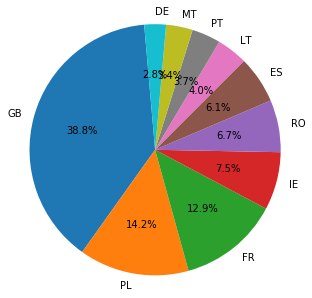

In [69]:
rcParams['figure.figsize'] = 5, 5

# Data to plot
labels = weekly_signups_stats.country.head(10)
sizes = weekly_signups_stats['mean'].head(10)

# Plot
plt.pie(sizes, labels=labels, startangle=95, autopct='%1.1f%%')

plt.axis('equal')
plt.show()

##### b) Query to calculate the volume of monthly card payment in USD per age group in the interval of 10.

I found the wording of this question a little confusing, so I have listed my assumptions in the query code. I have also selected a random cohort of users, and tracked their behaviour to identify engagement with the product. 

Even though the table is a nice way of summarizing how the different age groups are engaging, it still requires a bit of analysis and work from the product owner to understand growth patterns. I have visualized the results in [Fig_1](#Fig_1), and summarised some of the findings:

1. There is a drop in the volume of monthly card payments amongst 18-37 year olds towards the end of 2018.
2. Volatility in monthly card payments volume amomgst the 38-47 year old users, but overall this age group has the highest volume of transactions.
3. There is a slight increase in volume amongst the 58+ group.

In [5]:
query = """
    WITH volume AS (
        SELECT user_id
               ,date_trunc('month', created_date) AS month
               ,amount_usd
        FROM transactions
        -- assuming we are only interested in customers where transaction currency is USD 
        -- and considering all transaction states
        WHERE transactions_type = 'CARD_PAYMENT' AND transactions_currency = 'USD'
        -- only considering customers belonging to May 2018 cohort to test if these users are engaging with product
        AND user_id IN (
            SELECT user_id
            FROM (
                SELECT user_id
                ,min(date_trunc('month', created_date)) as cohort
                FROM users
                GROUP BY user_id) AS t1
            WHERE cohort = '2018-05-01')),
        -- sub table to calculate age and age group
        users_age_group AS (
             WITH users_age AS (
                SELECT *
                ,date_part('year', CURRENT_DATE) - birth_year AS age
                FROM users)
            SELECT user_id
                   ,age 
                   ,CASE WHEN age < 28 THEN '18-27' 
                         WHEN age < 38 THEN '28-37'
                         WHEN age < 48 THEN '38-47'
                         WHEN age < 58 THEN '48-57'
                         WHEN age < 68 THEN '58-67'
                         WHEN age < 78 THEN '68-77'
                         -- very small portion of customers over 77 (25 customers)
                         ELSE '78+'
                    END AS age_group
            FROM users_age)

    SELECT age_group
          ,month
          ,SUM(amount_usd) AS monthly_volume_usd
    FROM volume AS t1
    LEFT JOIN users_age_group AS t2 ON t1.user_id = t2.user_id
    GROUP BY age_group, month
    ORDER BY age_group, month;
    
"""

monthly_volume_age_group = pd.read_sql_query(query, cnx)

monthly_volume_age_group.head(20)


,age_group,month,monthly_volume_usd
0,18-27,2018-05-01,129.37
1,18-27,2018-06-01,7562.30
2,18-27,2018-07-01,5384.25
3,18-27,2018-08-01,7511.11
4,18-27,2018-09-01,1841.72
5,18-27,2018-10-01,2426.19
6,18-27,2018-11-01,3370.66
7,18-27,2018-12-01,1655.89
8,18-27,2019-01-01,2753.87
9,18-27,2019-02-01,1080.70


<a id="Fig_1"></a>

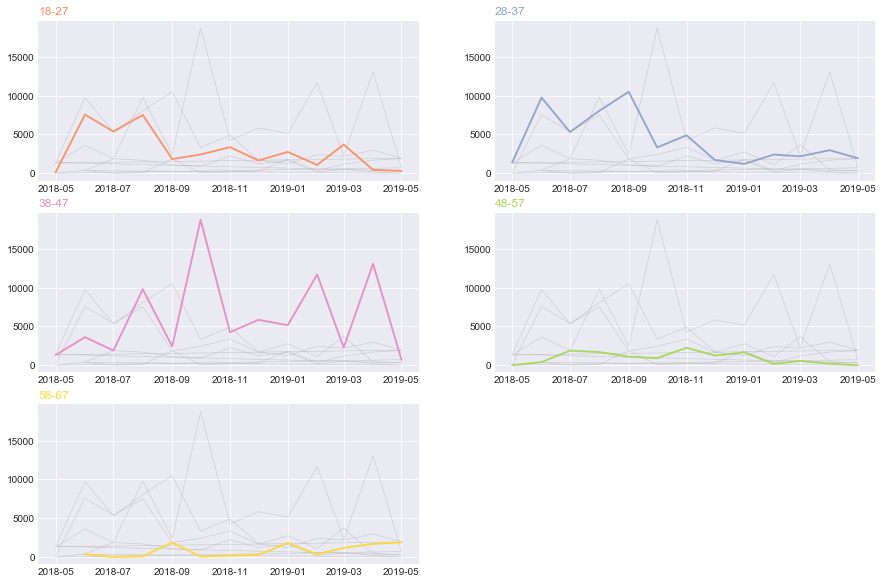

In [6]:
# code to visualize the monthly volume table

rcParams['figure.figsize'] = 15, 10

plt.style.use('seaborn-darkgrid')
 
palette = plt.get_cmap('Set2')

num=0
for column in list(np.unique(monthly_volume_age_group.age_group)):
    num+=1
    
    plt.subplot(3,2, num)
    
    # plot every group, but discreet
    plt.plot(monthly_volume_age_group['month'], monthly_volume_age_group['monthly_volume_usd'], marker='', color='grey', linewidth=0.6, alpha=0.3)
  
    # subset the dataframe by age group to highlight and plot one age group
    data = monthly_volume_age_group[monthly_volume_age_group.age_group == column]
    plt.plot(data['month'], data['monthly_volume_usd'], marker='', color=palette(num), linewidth=1.9, alpha=0.9, label=column);
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num))


##### c) Write a query to show the number of days where the average card payments volume of non standard users is less than standard users. 

For roughly one third of the year, standard customers have an average card payment volume higher than non standard users. 

In [7]:
query = """
    WITH standard_users AS (
        SELECT date_trunc('day', created_date) AS created_date_trunc
                -- assuming we are interested in the daily average spend across all currencies for standard users
                ,AVG(amount_usd) AS standard_avg_spend
        FROM transactions
        WHERE user_id IN (
            SELECT user_id
            FROM users
            WHERE plan = 'STANDARD')
        GROUP BY date_trunc('day', created_date)
        ORDER BY date_trunc('day', created_date)),
    non_standard_users AS (
        SELECT date_trunc('day', created_date) AS created_date_trunc
                -- assuming we are interested in the daily average spend across all currencies for non standard users
                ,AVG(amount_usd) AS non_standard_avg_spend
        FROM transactions
        WHERE user_id in (
            SELECT user_id
            FROM users
            WHERE plan <> 'STANDARD')
            GROUP BY date_trunc('day', created_date)
            ORDER BY date_trunc('day', created_date))

    SELECT COUNT(*) AS number_days
    FROM standard_users AS t1
    LEFT JOIN non_standard_users AS t2 ON t1.created_date_trunc=t2.created_date_trunc
    WHERE standard_avg_spend > non_standard_avg_spend
"""

number_days = pd.read_sql_query(query, cnx)

number_days


,number_days
0,150


## Part 2 - Data Exploration and Analysis

### a) Define a target metric to measure user engagement. How would you define an engaged vs. unengaged user?

One potential target metric for measuring user engagement is the number of transactions a user makes in a specific time period. 

To define an engaged vs. an unengaged user, and to build a model for the next part, I have created a table which aggregates the transactions table to a user level. This table includes features such as the first time they made a transaction, their tenure and the number of days since they last made a transaction.

I have also assumed the data provided is for a product similar to a current account, so I would expect "engaged" users to use their account on a regular basis and to have been active in the last 30 days. 

Based on the transaction behaviour of customers that have used their account in the last 30 days, I would define an engaged user as someone who makes at least one transaction every five days (the 25th percentile of the average transaction rate for that group, see [Fig_2](#Fig_2)), and an unengaged user as someone who makes less transactions than that.

### b) Build a model (heuristic/statistical/ML) to classify engaged and unengaged users

##### Making the training data set

In [5]:
# import data

devices = pd.read_sql_query("""SELECT * 
                               FROM devices;
                               """, cnx)
print(devices.shape)
devices.head()

(19430, 2)


,brand,user_id
0,Android,user_3257
1,Apple,user_6809
2,Android,user_9144
3,Apple,user_3636
4,Android,user_5970


In [6]:
devices.brand.value_counts()

Android    9714
Apple      9673
Unknown      43
Name: brand, dtype: int64

In [7]:
notifications = pd.read_sql_query("""SELECT * 
                                     FROM notifications;
                                     """, cnx)
print(notifications.shape)
notifications.head()

(121813, 5)


,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4151,2018-12-04 02:57:56.425660
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_1408,2018-12-11 02:04:46.284683
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6292,2018-12-14 17:09:58.900808


In [8]:
notifications.reason.value_counts()

REENGAGEMENT_ACTIVE_FUNDS               35844
FIFTH_PAYMENT_PROMO                     23743
NO_INITIAL_CARD_USE                     11221
NO_INITIAL_CARD_ORDER                   11136
METAL_GAME_START                         8373
LOST_CARD_ORDER                          6146
NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER     5459
JOINING_ANNIVERSARY                      4158
MADE_MONEY_REQUEST_NOT_SPLIT_BILL        3506
ONBOARDING_TIPS_ACTIVATED_USERS          3145
ENGAGEMENT_SPLIT_BILL_RESTAURANT         2298
BLACK_FRIDAY                             2109
METAL_RESERVE_PLAN                       1233
PREMIUM_ENGAGEMENT_INACTIVE_CARD         1124
WELCOME_HOME                              950
PUMPKIN_PAYMENT_NOTIFICATION              690
PREMIUM_ENGAGEMENT_FEES_SAVED             678
Name: reason, dtype: int64

In [9]:
transactions = pd.read_sql_query("""SELECT * 
                                    FROM transactions
                                    -- excluding transaction types that I believe are passive
                                    WHERE transactions_type NOT IN ('FEE', 'TAX', 'REFUND', 'CARD_REFUND')
                                    ORDER BY user_id, created_date;
                                    """, cnx)

print(transactions.shape)
transactions.head()

(2700132, 12)


,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_362571,TOPUP,PLN,0.20,REVERTED,None,NaN,None,None,INBOUND,user_0,2018-01-16 23:23:48.330466
1,transaction_237281,TOPUP,PLN,39.77,COMPLETED,None,NaN,None,None,INBOUND,user_0,2018-01-16 23:24:18.666466
2,transaction_233675,EXCHANGE,PLN,37.78,COMPLETED,None,NaN,None,None,OUTBOUND,user_0,2018-01-17 01:39:17.613466
3,transaction_546121,TRANSFER,EUR,5.66,COMPLETED,None,NaN,None,None,OUTBOUND,user_0,2018-01-17 01:52:38.943466
4,transaction_545586,TRANSFER,EUR,4.26,COMPLETED,None,NaN,None,None,OUTBOUND,user_0,2018-01-17 07:49:06.142466


In [10]:
# users with age, age category and plan grouped

query = """
    WITH users_age_group AS (
             WITH users_age AS (
                SELECT *
                ,date_part('year', CURRENT_DATE) - birth_year AS age
                FROM users)
            SELECT * 
                   ,CASE WHEN age < 28 THEN '18-27' 
                         WHEN age < 38 THEN '28-37'
                         WHEN age < 48 THEN '38-47'
                         WHEN age < 58 THEN '48-57'
                         WHEN age < 68 THEN '58-67'
                         WHEN age < 78 THEN '68-77'
                         -- very small portion of customers over 77 (25 customers)
                         ELSE '78+'
                    END AS age_group
                    ,CASE WHEN plan = 'STANDARD' THEN 'STANDARD'
                          ELSE 'NON-STANDARD' 
                    END AS plan_group
                   
            FROM users_age)

    SELECT *      
    FROM users_age_group;
"""

users = pd.read_sql_query(query, cnx)

print(users.shape)
users.head()

(19430, 15)


,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,age,age_group,plan_group
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,0,0,30.0,28-37,STANDARD
1,user_1,1975,GB,London,2018-01-29 03:38:46.676876,0,STANDARD,NaN,NaN,21,0,0,44.0,38-47,STANDARD
2,user_2,1987,PL,Poznań,2018-01-18 19:17:31.229096,0,STANDARD,0.0,0.0,21,0,0,32.0,28-37,STANDARD
3,user_3,1994,FR,Paris,2018-01-15 18:47:56.723104,0,STANDARD,1.0,0.0,0,0,0,25.0,18-27,STANDARD
4,user_4,1985,GB,Beckenham,2018-01-11 00:36:46.673673,0,STANDARD,NaN,NaN,2,0,0,34.0,28-37,STANDARD


In [11]:
from functools import reduce

# aggregate data to create a user level table --- TIDY THIS CODE 

# first transaction date
df_1 = pd.DataFrame(
           transactions.groupby('user_id').created_date.first()).rename(
               columns={"created_date": "first_transaction_date"})

# last transaction date
df_2 = pd.DataFrame(
            transactions.groupby('user_id').created_date.last()).rename(
                columns={"created_date": "last_transaction_date"})


# total number of transactions
df_3 = pd.DataFrame(
            transactions.groupby('user_id').transaction_id.count()).rename(
                columns={"transaction_id": "total_transactions"})

dfs = [df_1, df_2, df_3]

user_transactions_agg = reduce(lambda left,right: pd.merge(left,right,on='user_id'), dfs)

# number of days since last transaction since May 2019 (cut off date of dataset)

user_transactions_agg['recency_days'] = user_transactions_agg['last_transaction_date'].max() - user_transactions_agg['last_transaction_date']
user_transactions_agg['recency_days'] = user_transactions_agg['recency_days'].dt.days.astype('int16')


In [12]:
# merge user level transaction features onto orignal users table
user_agg = user_transactions_agg.merge(users, on="user_id")

# tenure of user
user_agg['tenure_days'] = user_agg['last_transaction_date'].max() - user_agg['created_date']
user_agg['tenure_days'] = user_agg['tenure_days'].dt.days.astype('int16')

# average transaction rate - could be used as a proxy measure to define user engagement
user_agg['avg_transaction_rate'] = round(user_agg['total_transactions']/user_agg['tenure_days'],2)

# merge devices
user_agg = user_agg.merge(devices, on="user_id")

In [13]:
# drop columns that are not going to used in the model
user_agg.drop(['first_transaction_date', 
               'last_transaction_date',
               'created_date',
               'birth_year',
               # Due to time limitations, dropping cities, and using just country. 
               # Also, spotted combinations of city names and postcodes in the city field
               'city',
               # using age group instead of age
               'age',
               'plan'], axis=1, inplace=True)

In [14]:
# pickle file
user_agg.to_pickle("../data/processed/user_agg.pkl")

##### Creating and exploring the target variable: Engagement

In [15]:
user_agg = pd.read_pickle("../data/processed/user_agg.pkl")

user_agg.head()

,user_id,total_transactions,recency_days,country,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,age_group,plan_group,tenure_days,avg_transaction_rate,brand
0,user_0,385,14,PL,1,1.0,1.0,3,0,0,28-37,STANDARD,488,0.79,Apple
1,user_1,126,78,GB,0,NaN,NaN,21,0,0,38-47,STANDARD,472,0.27,Apple
2,user_10,1046,5,FR,0,1.0,1.0,38,0,0,38-47,STANDARD,497,2.10,Apple
3,user_100,130,9,GB,0,NaN,NaN,0,0,0,48-57,STANDARD,486,0.27,Apple
4,user_1000,39,324,GB,1,1.0,1.0,0,0,0,58-67,STANDARD,495,0.08,Android


<a id="Fig_2"></a>

In [93]:
user_agg.avg_transaction_rate[user_agg.recency_days < 30].shape[0]/user_agg.shape[0]*100

58.36445108289768

count    10941.000000
mean         0.749621
std          0.969945
min          0.000000
25%          0.190000
50%          0.420000
75%          0.920000
max         21.880000
Name: avg_transaction_rate, dtype: float64


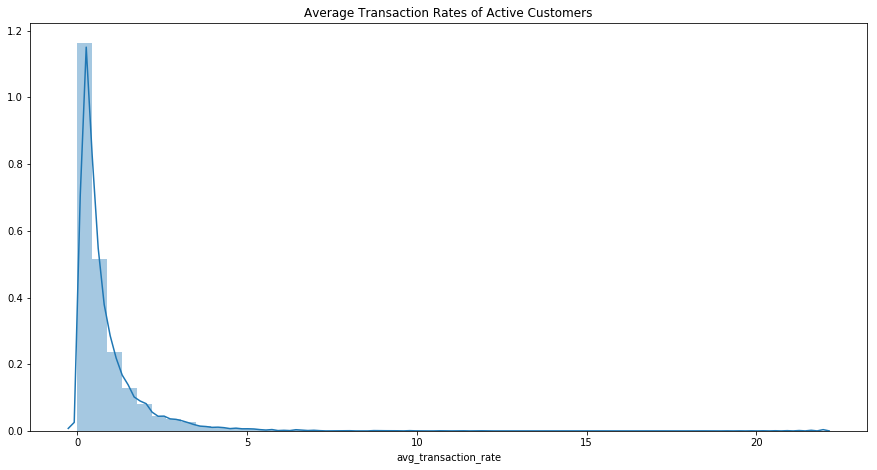

In [75]:
# distribution of average transaction rate
rcParams['figure.figsize'] = 15, 7.5

# transaction rates of customrs who have been active in the last 30 days, to define user engagement
sns.distplot(user_agg[user_agg.recency_days < 30].avg_transaction_rate).set_title('Average Transaction Rates of Active Customers');

print(user_agg.avg_transaction_rate[user_agg.recency_days < 30].describe())

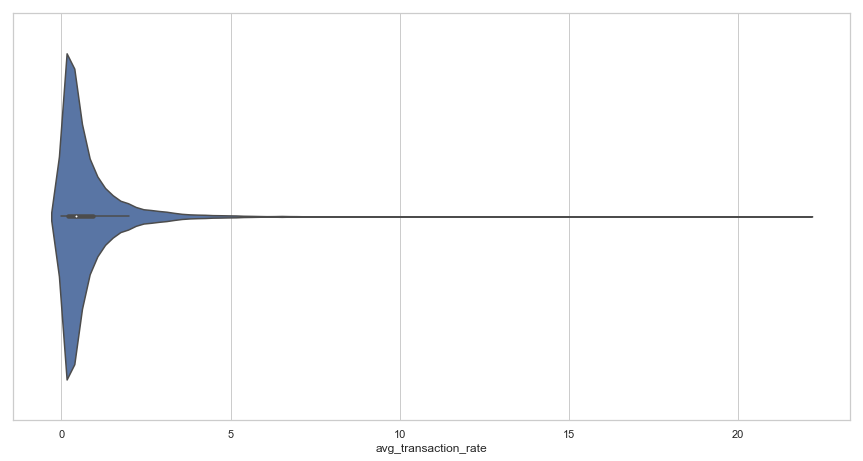

In [83]:
sns.set(style="whitegrid")
sns.violinplot(user_agg.avg_transaction_rate[user_agg.recency_days < 30]);

In [17]:
# create target variable, where 1 is an engaged user and 0 is an unengaged user
# no imbalanced data issues

user_agg.loc[user_agg.avg_transaction_rate >= 0.2, 'engaged_user'] = "Yes" 
user_agg.loc[user_agg.avg_transaction_rate < 0.2, 'engaged_user'] = "No"

# user_agg.drop(['avg_transaction_rate'], axis=1, inplace=True)

user_agg.engaged_user.value_counts()

Yes    9796
No     8950
Name: engaged_user, dtype: int64

##### Exploring the Data

In [18]:
# shape of dataset

print("# of users:", user_agg.shape[0])

user_agg.head()

# of users: 18746


,user_id,total_transactions,recency_days,country,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,age_group,plan_group,tenure_days,avg_transaction_rate,brand,engaged_user
0,user_0,385,14,PL,1,1.0,1.0,3,0,0,28-37,STANDARD,488,0.79,Apple,Yes
1,user_1,126,78,GB,0,NaN,NaN,21,0,0,38-47,STANDARD,472,0.27,Apple,Yes
2,user_10,1046,5,FR,0,1.0,1.0,38,0,0,38-47,STANDARD,497,2.10,Apple,Yes
3,user_100,130,9,GB,0,NaN,NaN,0,0,0,48-57,STANDARD,486,0.27,Apple,Yes
4,user_1000,39,324,GB,1,1.0,1.0,0,0,0,58-67,STANDARD,495,0.08,Android,No


In [19]:
# data structure 
user_agg.columns.to_series().groupby(user_agg.dtypes).groups

{dtype('int16'): Index(['recency_days', 'tenure_days'], dtype='object'),
 dtype('int64'): Index(['total_transactions', 'user_settings_crypto_unlocked', 'num_contacts',
        'num_referrals', 'num_successful_referrals'],
       dtype='object'),
 dtype('float64'): Index(['attributes_notifications_marketing_push',
        'attributes_notifications_marketing_email', 'avg_transaction_rate'],
       dtype='object'),
 dtype('O'): Index(['user_id', 'country', 'age_group', 'plan_group', 'brand',
        'engaged_user'],
       dtype='object')}

In [20]:
# overview of numerical features
user_agg.describe()

,total_transactions,recency_days,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,tenure_days,avg_transaction_rate
count,18746.000000,18746.000000,18746.000000,12201.000000,12201.00000,18746.000000,18746.0,18746.0,18746.000000,18746.000000
mean,144.037768,70.413528,0.185213,0.945660,0.89550,18.428518,0.0,0.0,298.058572,0.493950
std,243.742826,101.150784,0.388480,0.226696,0.30592,47.219403,0.0,0.0,104.537540,0.813158
min,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,133.000000,0.000000
25%,17.000000,6.000000,0.000000,1.000000,1.00000,0.000000,0.0,0.0,207.000000,0.060000
50%,59.000000,18.000000,0.000000,1.000000,1.00000,5.000000,0.0,0.0,290.000000,0.210000
75%,164.000000,94.000000,0.000000,1.000000,1.00000,20.000000,0.0,0.0,384.000000,0.560000
max,5272.000000,498.000000,1.000000,1.000000,1.00000,2918.000000,0.0,0.0,500.000000,21.880000


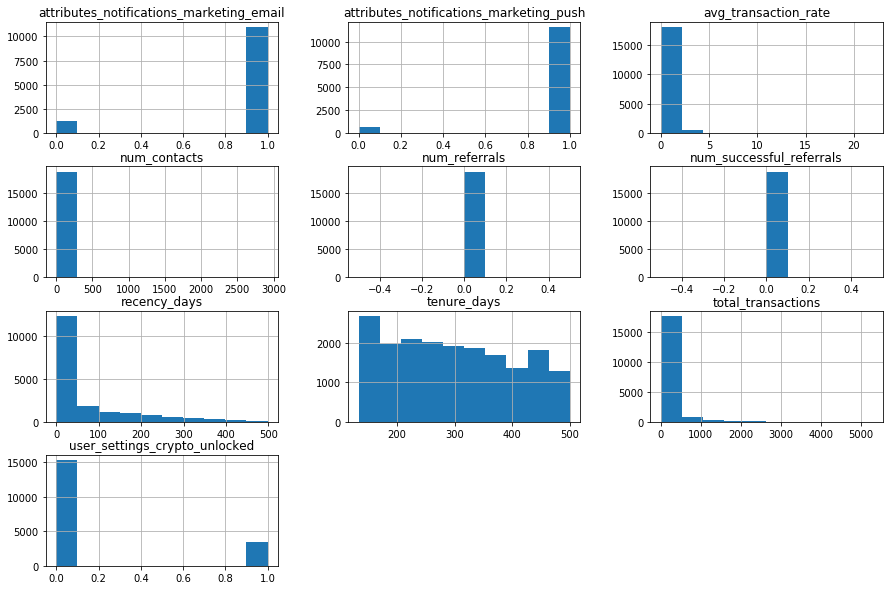

In [21]:
# most of the variables, aside from tenure have skewed distiributions
user_agg.hist(figsize=(15,10));

/Users/shaq/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


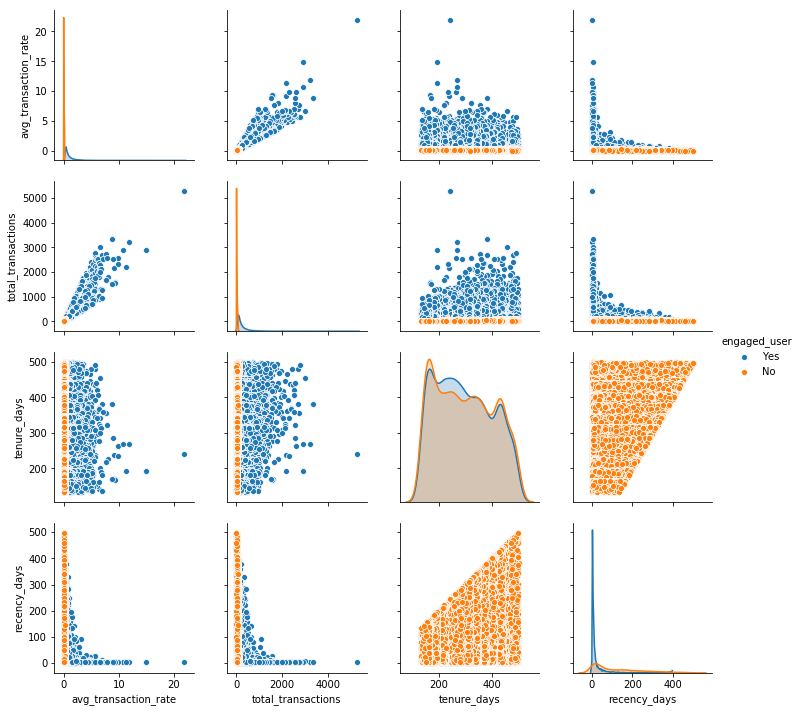

In [22]:
rcParams['figure.figsize'] = 5, 2.5

sample = user_agg[['avg_transaction_rate', 'total_transactions', 'tenure_days', 'recency_days', 'engaged_user']]

sns.pairplot(sample, hue='engaged_user');

In [23]:
# drop tenure from dataset
# this feature is not correctly calculated, as I do not know when/if customers churned
# this does not fit into an engagement model

user_agg_interim = user_agg.drop(['tenure_days'], axis=1)

##### Feature Selection

In [24]:
# Feature Selection, using a class I built to find highly correlated variables, single values and missing values

fs = FeatureSelector(user_agg_interim, 'engaged_user')

fs.identify_all(selection_params={'missing_threshold': 0.4,    
                                    'correlation_threshold': 0.75
                                   })


0 features with greater than 0.40 missing values.

2 features with a single unique value.

1 features with a correlation magnitude greater than 0.75.

3 total features out of 15 identified for removal.



In [25]:
# list the features to be removed
fs.check_removal()

Total of 3 features identified for removal


['num_referrals', 'num_successful_referrals', 'avg_transaction_rate']

In [26]:
# missing data

fs.missing_stats.head(25)

,missing_fraction
attributes_notifications_marketing_push,0.349141
attributes_notifications_marketing_email,0.349141
user_id,0.000000
total_transactions,0.000000
recency_days,0.000000
country,0.000000
user_settings_crypto_unlocked,0.000000
num_contacts,0.000000
num_referrals,0.000000
num_successful_referrals,0.000000


In [27]:
# fill nas with 0

user_agg_interim.fillna(0, inplace=True)

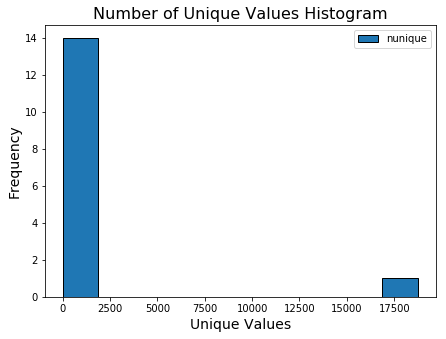

In [28]:
# single value features

fs.plot_unique()

In [29]:
unique_features = fs.ops['single_unique']
unique_features

['num_referrals', 'num_successful_referrals']

In [30]:
# identify correlated features

fs.identify_collinear(correlation_threshold=0.75)

2 features with a correlation magnitude greater than 0.75.



In [31]:
fs.record_collinear

,corr_feature,drop_feature,corr_values
0,total_transactions,avg_transaction_rate,0.93
1,attributes_notifications_marketing_push,attributes_notifications_marketing_email,0.92


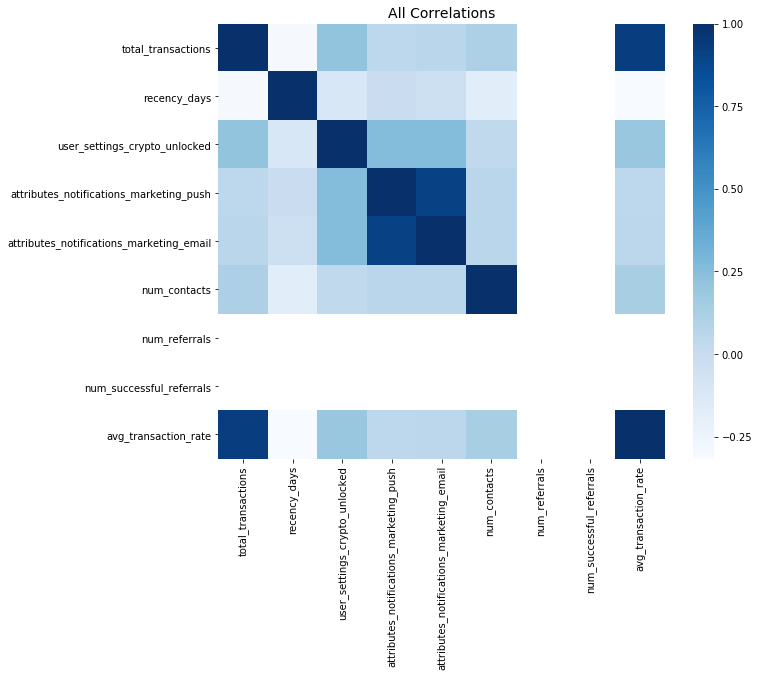

In [32]:
fs.plot_collinear()

In [33]:
# remove features identified

user_agg_interim = fs.remove(methods='all')

user_agg_interim.shape

['missing', 'single_unique', 'collinear'] methods have been run

Removed 4 features.

 ['num_referrals', 'attributes_notifications_marketing_email', 'num_successful_referrals', 'avg_transaction_rate']


(18746, 11)

##### Preprocessing Data

In [36]:
def make_dummy_var(data, var):
    """specify dataset and variable names to hot encode"""
    one_hot = pd.get_dummies(data[var], prefix=var)
    data.drop(var, axis=1, inplace=True)
    data = data.join(one_hot)

    return data

In [37]:
# hot encoding the categorical data
# if time, look into best way to encode country, which has multiple categories

user_agg_final = make_dummy_var(user_agg_interim, ['age_group', 'country', 'brand', 'plan_group'])


In [38]:
# encode target column

user_agg_final['engaged_user'] = user_agg_interim ['engaged_user'].replace({'No': 0, 'Yes': 1})

In [39]:
# drop user_id

user_agg_final.drop(['user_id'], inplace=True, axis=1)

user_agg_final.head()

,total_transactions,recency_days,user_settings_crypto_unlocked,attributes_notifications_marketing_push,num_contacts,engaged_user,age_group_18-27,age_group_28-37,age_group_38-47,age_group_48-57,...,country_RE,country_RO,country_SE,country_SI,country_SK,brand_Android,brand_Apple,brand_Unknown,plan_group_NON-STANDARD,plan_group_STANDARD
0,385,14,1,1.0,3,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
1,126,78,0,0.0,21,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2,1046,5,0,1.0,38,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,130,9,0,0.0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,39,324,1,1.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [40]:
# scaling numerical features to a range between 0 and 1
# not necessary for decision tree algorithms, but can improve other ML algorithms performance.
# 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
col = list(user_agg_final.columns)
col.remove('engaged_user')
for col in col:
    user_agg_final[col] = user_agg_final[col].astype(float)
    user_agg_final[[col]] = scaler.fit_transform(user_agg_final[[col]])
user_agg_final.head()


,total_transactions,recency_days,user_settings_crypto_unlocked,attributes_notifications_marketing_push,num_contacts,engaged_user,age_group_18-27,age_group_28-37,age_group_38-47,age_group_48-57,...,country_RE,country_RO,country_SE,country_SI,country_SK,brand_Android,brand_Apple,brand_Unknown,plan_group_NON-STANDARD,plan_group_STANDARD
0,0.072851,0.028112,1.0,1.0,0.001028,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.023715,0.156627,0.0,0.0,0.007197,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.198255,0.010040,0.0,1.0,0.013023,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.024474,0.018072,0.0,0.0,0.000000,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.007209,0.650602,1.0,1.0,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [41]:
# split data into train and test

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, scorer, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

target_data = user_agg_final['engaged_user']
features = user_agg_final.drop(['engaged_user'], axis=1)
    

# store evaluation metrics in a dataframe
X_train, X_test, y_train, y_test = train_test_split(
                                                features, target_data,
                                                test_size=0.3, random_state=0)
    

##### Building the model

In [42]:
print("Training Data")
print(X_train.shape)
print(y_train.shape)
print("\nTest Data")
print(X_test.shape)
print(y_test.shape)

Training Data
(13122, 58)
(13122,)

Test Data
(5624, 58)
(5624,)


###### Model Selection

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# model selection
models = []
# using Dummy Classifier as one baseline algorithm
models.append(('Dummy Classifier', DummyClassifier(strategy='stratified')))
# using Logistic Regression as another baseline algorithm, to see if anything more advanced if necessary
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state=7,
                                                         class_weight='balanced')))
# chose Random Forest and XGBoost, as powerful supervised learning algorithms and provide feature importance
models.append(('Random Forest', RandomForestClassifier(
    n_estimators=100)))
models.append(('XGBoost', XGBClassifier(n_jobs=-1, verbose=2)))


In [44]:
scoring_df = []

for name, models in models:
    cv_acc_results = cross_val_score(  
        models, X_train, y_train, cv=5, scoring='accuracy')
    cv_auc_results = cross_val_score(  
        models, X_train, y_train, cv=5, scoring='roc_auc')
    
    scoring_dict = {'Model Name': name,
                    'Accuracy Mean': round(cv_acc_results.mean(),2), 
                    'ROC Mean': round(cv_auc_results.mean(),2)
                    }
    
    scoring_df.append(scoring_dict)

In [45]:
scoring_df = pd.DataFrame(scoring_df)

scoring_df[['Model Name', 'Accuracy Mean', 'ROC Mean']]

,Model Name,Accuracy Mean,ROC Mean
0,Dummy Classifier,0.51,0.49
1,Logistic Regression,0.83,0.92
2,Random Forest,0.93,0.98
3,XGBoost,0.93,0.99


Build the engagement model using XGBoost, as it has the highest average accuracy and ROC.

###### Model Evaluation

In [46]:
# best performing model
model = XGBClassifier(n_jobs=-1, verbose=2)


In [47]:
# class I created to evaluate model - confusion matrix, learning curve, feature imp
pipe = MLPipeline(X_train,X_test, y_train, y_test, model)

In [48]:
# best model score evaluation - no signs of overfitting
pipe.score()

{'Accuracy (Test Data)': 0.93,
 'Accuracy (Train Data)': 0.93,
 'F1-Score (Test Data)': 0.93,
 'F1-Score (Train Data)': 0.93}

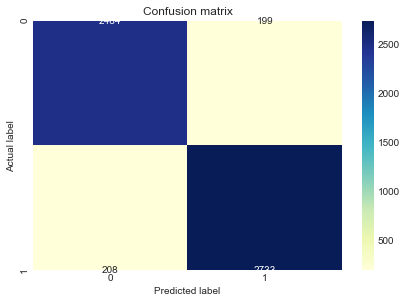

In [49]:
# confusion matrix for best model - labels need aligning 
pipe.plot_confusion_matrix()

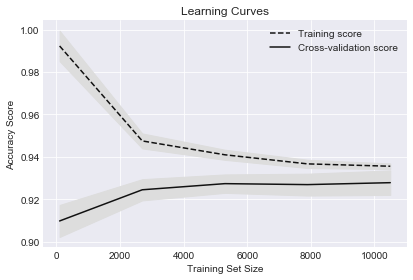

In [50]:
# learning curve for best model
pipe.plot_learning_curves()

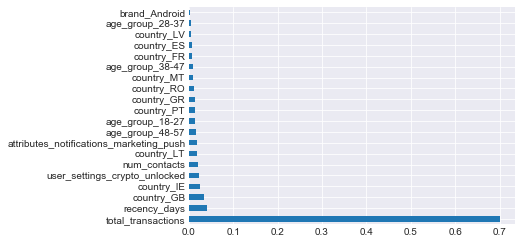

In [51]:
# plot feature importance
pipe.feature_importance_plot()


Remarks:

1. Total transactions are the best features when it comes to explaining user engagement (this makes sense, the more transactions, the more engaged a user is), followed by the number of days since a users last transaction and whether they are a GB or IE user.
2. Adding more data (features in this case) will help improve the robustness of the model, as indicated in the slight gap in the learning curve.


### c) How would you set up a test/experiment to check whether we are actually reducing churn?

Very simply, I could track the churn rate of all users over the course of the next few months against a forecasted churn rate (if my model was not implemented) and compare the two. 

Another option would be to provide the business with a sample of users with a high probability of churning (test group), for them to take action, and keep a sample (control group) so I can monitor whether churn is actually being reduced. The null hypothesis would be, the test group will have a lower churn, than the control group, who do not receive any business intervention. To determine if the test is working we would then need to check the uptick in the test group is statistically significant. 

This is similar to the hypothesis testing I did for measuring campaign effectiveness. Refer to [Hypothesis_Testing](#Hypothesis_Testing)

### d) Define a metric to measure the effectiveness of the campaign. Under this metric, was the campaign effective?

One way of assessing the effectiveness of the campaign would be to look at the transaction rate/ number of transactions of the user before the campaign was sent, and compare that to the transaction rate of users after the notification was sent. If we see an increase in transactions, we can say the campaign was effective.

From the data provided, I looked at the average number of transactions recorded for users before and after the campaign was sent, and conducted a t-test to check the statistical significance of the results. After the campaign was sent, we can see a 31% increase in transactions amongst users, which is statistically significant, indicating the campaign was effective.

In [52]:
# create a table to understand transaction rates before and after the campaign was sent to the user

# list of users who were sent the campaign
users_campaign = notifications[(notifications.reason == "REENGAGEMENT_ACTIVE_FUNDS") &
              (notifications.status == "SENT")][['user_id', 'created_date']].rename(
                    columns={"created_date": "campaign_date"})

print(users_campaign.shape)

transaction_reduced = transactions[transactions.user_id.isin(users_campaign.user_id)]

users_campaign = users_campaign.merge(transaction_reduced, on="user_id")

(28139, 2)


In [53]:
# identify transactions that were made before and after the campaign was sent
users_campaign['reengagement_fund_flag'] = users_campaign.apply(lambda x: 1
                            if x['created_date'] >= x['campaign_date']
                            else 0,
                            axis = 1)

In [54]:
# average number of transactions before campaign was sent 
users_campaign_w_transaction = users_campaign[users_campaign['reengagement_fund_flag'] == 0]

print("average number of transactions before campaign was sent")
print(pd.DataFrame(
            users_campaign_w_transaction.groupby('user_id').transaction_id.count()).rename(
                columns={"transaction_id": "average_transactions"}).mean())

average number of transactions before campaign was sent
average_transactions    123.834414
dtype: float64


In [55]:
# average number of transactions after campaign was sent 
users_campaign_w_transaction = users_campaign[users_campaign['reengagement_fund_flag'] == 1]

print("average number of transactions after campaign was sent")
print(pd.DataFrame(
            users_campaign_w_transaction.groupby('user_id').transaction_id.count()).rename(
                columns={"transaction_id": "average_transactions"}).mean())

print(pd.DataFrame(
            users_campaign_w_transaction.groupby('user_id').transaction_id.count()).rename(
                columns={"transaction_id": "std_transactions"}).std())

average number of transactions after campaign was sent
average_transactions    161.976657
dtype: float64
std_transactions    247.748021
dtype: float64


<a id="Hypothesis_Testing"></a>

In [56]:
# H0: There is no significant difference in the average transactions
# H1: There is significant difference in the average transactions

# calculating t test value

sample_mean = 162
population_mean = 124

sample_size = 28139

degree_of_freedom = sample_size - 1
standard_deviation = 248

In [57]:
# T-score
Ttest = (sample_mean - population_mean) / (standard_deviation/np.sqrt(sample_size))

print("T Test Value is:", Ttest)

T Test Value is: 25.70314377456466


In [58]:
p = stats.t.cdf(Ttest, df = degree_of_freedom)
pvalue = stats.t.sf(np.abs(Ttest),degree_of_freedom)*2

# if < 0.05 reject the null hypothesis
print("pvalue is:", pvalue)

pvalue is: 4.964651087312229e-144
